In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from data_generators import DiodeDataGenerator
from data_generators import RsDiodeDataGenerator
from diode import DIODE


data_set_folder = "/val/"
split = 'val'
scene_type =  'indoors'
meta_fname = './diode_meta.json'
data_root = '/home/colin/projects/QMIND-CV-Robot-Vision/depth-map-project/data/'
diode = DIODE(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root)

# Ensure annotation folder exists
if not os.path.exists(os.path.abspath("./data") + data_set_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("./data"),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

dim = (256, 256, 3)
tf.random.set_seed(123)



In [12]:
# Model definition
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Conv2D, UpSampling2D,  LeakyReLU, Concatenate, BatchNormalization
from tensorflow.keras import Model


class UpSamplingBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(UpSamplingBlock, self).__init__()
        self.up_sampling = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.concat = Concatenate()
        self.convA = Conv2D(filters=filters, kernel_size=(3,3), padding='same')
        self.batch_normA = BatchNormalization()
        self.reluA = LeakyReLU()
        self.convB = Conv2D(filters=filters, kernel_size=(3,3), padding='same')
        self.batch_normB = BatchNormalization()
        self.reluB = LeakyReLU()   
        
    def call(self, input):
        """ input is a 2 element list, first element is the input tensor, second element is the tensor to be concatenated from encoder
        """
        x = self.up_sampling(input[0])
        x = self.concat([x, input[1]])
        x = self.convA(x)
        x = self.batch_normA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.batch_normB(x)
        x = self.reluB(x)
        return x
    

class encoder(tf.keras.layers.Layer):
    def __init__(self, dim):
        super(encoder, self).__init__()
        self.dense_net = DenseNet201(input_shape=(dim[0], dim[1], 3), include_top=False, weights='imagenet') 
        for layer in self.dense_net.layers:
            layer.trainable = True

        dense_net_layer_output_names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
        outputs = [self.dense_net.output]
        for name in dense_net_layer_output_names:
            outputs.append(self.dense_net.get_layer(name).output)

        self.encoder = Model(inputs=self.dense_net.input, outputs=outputs)


    def call(self, inputs):
        return self.encoder(inputs)
    

class decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(decoder, self).__init__()
        self.covA = Conv2D(filters=1664, kernel_size=(1,1), padding='same')
        self.up_block1 = UpSamplingBlock(filters=832)
        self.up_block2 = UpSamplingBlock(filters=416)
        self.up_block3 = UpSamplingBlock(filters=208)
        self.up_block4 = UpSamplingBlock(filters=104)
        self.covB = Conv2D(filters=1, activation="sigmoid", kernel_size=(3,3), padding='same')

    def call(self, features):
        x = self.covA(features[0])
        x = self.up_block1([x, features[1]])
        x = self.up_block2([x, features[2]])
        x = self.up_block3([x, features[3]])
        x = self.up_block4([x, features[4]])
        x = self.covB(x)
        return x
        

class DepthEstimator(tf.keras.Model):
    def __init__(self, dim):
        super(DepthEstimator, self).__init__()
        self.encoder = encoder(dim)
        self.decoder = decoder()

    def call(self, inputs):
        features = self.encoder(inputs)
        depth = self.decoder(features)
        return depth

In [13]:
# build and train the model
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

def loss_function(y_true, y_pred):

  #Cosine distance loss
  depth_loss = tf.reduce_mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  grad_loss = tf.reduce_mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss assuming target range is 1
  ssim_loss = tf.clip_by_value((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  depth_loss_weight = 0.1
  return ssim_loss + tf.reduce_mean(grad_loss) + depth_loss_weight * tf.reduce_mean(depth_loss)


batch_size = 2
epochs = 10
lr = 0.0001

# Create the model
model = DepthEstimator(dim)
opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=1e-6,amsgrad=True)

# Compile the model
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

custom_data_generator = RsDiodeDataGenerator(diode_split=split, diode_scene_type=scene_type, diode_meta_name=meta_fname, data_root=data_root, batch_size=batch_size, dim=dim)


model.fit(custom_data_generator,epochs=epochs, shuffle=False)




Epoch 1/10


KeyboardInterrupt: 

TypeError: DiodeDataGenerator.pre_process_depth() missing 1 required positional argument: 'flip'

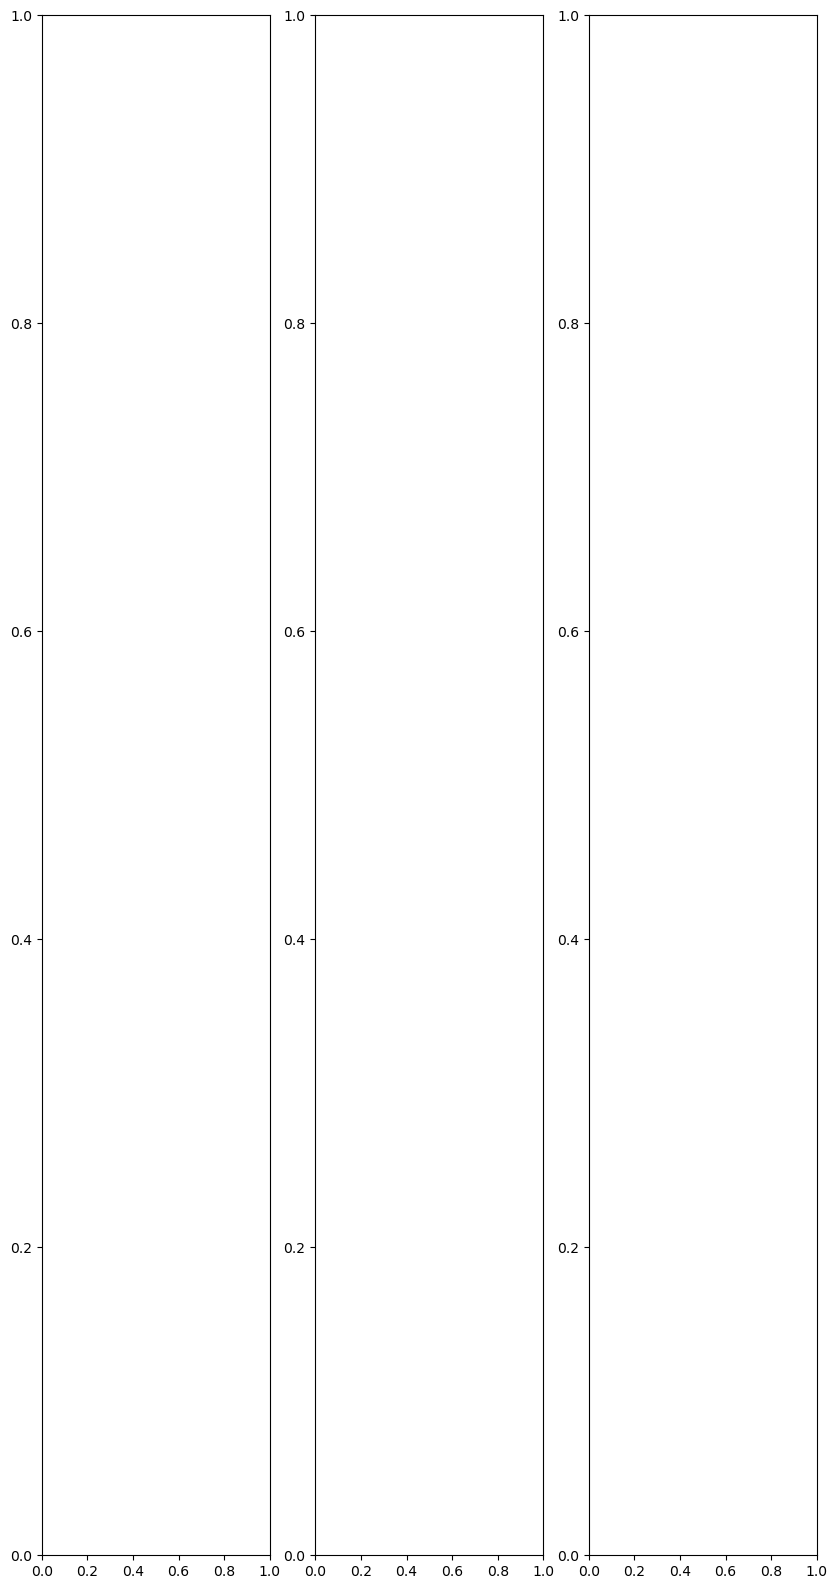

In [14]:
# display the results

num_tests = 50
custom_data_generator = DiodeDataGenerator(split="val", scene_types=scene_type, meta_fname=meta_fname, data_root=data_root, batch_size=1, dim=dim)

# Load and predict images one by one
for i in range(num_tests):
    _, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 20))  # Adjust as needed


    x, y, _= custom_data_generator.load(i)
    x = custom_data_generator.pre_process_image(x, False)
    y = custom_data_generator.pre_process_depth(y, False)
    
    x = np.expand_dims(x, axis=0)

    # Predict depth map
    y_pred = model.predict(x)

    # Plot original image, truth depth map, and predicted depth map using matplotlib
    axs[0].imshow(x[0])
    axs[0].set_title('Original Image')
    axs[1].imshow(y)
    axs[1].set_title('Truth Depth Map')
    axs[2].imshow(y_pred[0, :, :, 0])
    axs[2].set_title('Predicted Depth Map')

    # Remove axis for all subplots
    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()